<h1> I. Beginning </h1>

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

pd.options.display.max_rows = 100

/home/marc/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/marc/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

## Import Data

In [3]:
train = pd.read_csv('./data/train.csv', sep = ",")
test = pd.read_csv('./data/test.csv', sep = ",")

In [4]:
target = train['is_listened']
train.drop('is_listened',inplace=True,axis=1)
IDtest = test['sample_id']
test.drop('sample_id',inplace=True,axis=1)

In [5]:
test.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,50,1478104371,683078,82356,1,20021008,0,0,542,1,0,17698,2076,30
1,2744,1479317140,876497,99692,1,19851231,0,0,307,1,0,10525,26,28
2,2744,1479546361,876497,99692,1,19851231,0,0,307,1,0,8716,26,27
3,2744,1478457729,876500,99692,1,19851231,2,1,265,1,0,5443,26,30
4,2744,1480448560,876504,99692,1,19851231,2,1,356,1,0,7600,26,29


In [6]:
train.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24


### Combined contains the common columns to the test and train set, in order to apply the same transformations on all the data

In [7]:
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index',inplace=True,axis=1)
train['is_listened'] = target

In [8]:
combined.describe()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
count,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06,7.578752e+06
mean,2.243932e+03,1.479012e+09,7.838445e+07,8.134845e+06,2.359367e+00,2.011387e+07,4.731144e-01,2.556069e-01,2.311575e+02,3.086957e-01,3.937923e-01,4.052862e+03,1.500465e+06,2.431156e+01
std,1.308446e+04,1.188382e+07,5.133382e+07,5.459764e+06,4.656722e+00,7.569161e+04,7.350374e-01,5.480671e-01,7.997039e+01,4.619553e-01,4.885898e-01,3.972124e+03,2.519307e+06,3.768163e+00
min,0.000000e+00,1.000000e+00,2.000580e+05,1.976000e+03,0.000000e+00,1.900010e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01
25%,0.000000e+00,1.478461e+09,1.376614e+07,1.255467e+06,0.000000e+00,2.009123e+07,0.000000e+00,0.000000e+00,1.960000e+02,0.000000e+00,0.000000e+00,9.020000e+02,2.601000e+03,2.100000e+01
50%,3.000000e+00,1.479058e+09,9.374990e+07,9.519400e+06,1.000000e+00,2.014103e+07,0.000000e+00,0.000000e+00,2.220000e+02,0.000000e+00,0.000000e+00,2.747000e+03,1.941720e+05,2.500000e+01
75%,2.700000e+01,1.479743e+09,1.262328e+08,1.328944e+07,2.000000e+00,2.016061e+07,1.000000e+00,0.000000e+00,2.540000e+02,1.000000e+00,1.000000e+00,6.086000e+03,1.519461e+06,2.800000e+01
max,2.597310e+05,1.480637e+09,1.372601e+08,1.472086e+07,7.300000e+01,3.000010e+07,2.000000e+00,2.000000e+00,6.553500e+04,1.000000e+00,1.000000e+00,1.991700e+04,1.144741e+07,3.000000e+01


In [9]:
# Took the data from "input.csv"

# How to process it?

# Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)
# Ts_listen, release_date: date under 2 different formats -> put to same format
# Context_type -> one-hot-encode
# Platform_name, platform_family -> one-hot encode? Aggregate?
# Media_duration -> this one seems simple, keep as is
# Listen_type -> probably keep as is, but not sure
# User_gender -> keep as is (sexism!)
# User_age -> keep as is

# Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 
# Using the date, we can compute the number of songs he listened in a row

# I think the key here is correctly using the information about artist, etc...


<h1> II. Feature Preparation </h1>

In [10]:
# def medianNan(s):
#     global combined
#     combined[s].fillna(np.median(combined[~np.isnan(combined[s])][s]), inplace=True)

### Filling NaN values with the median of the column

In [11]:
# for s in combined.columns[1:]:
# #     print(s,type(combined[s][0]))
#     medianNan(s)

### Dealing with categoricals

In [12]:
categorical = ['platform_name', 'platform_family'] ## 'context_type' TOO BIG! (MemoryError)

In [13]:
def dummify(variable):
    global combined
    local_dummies = pd.get_dummies(combined[variable],prefix=variable)
    combined = pd.concat([combined,local_dummies],axis=1)
    combined.drop(variable,axis=1,inplace=True)

In [14]:
for s in categorical:
    dummify(s)

## DATA VISUALISATION

### Same user ID's in test and train

In [15]:
sorted(train['user_id'].unique()) == sorted(test['user_id'].unique())

True

### listen_type == 1 in test set (apart from one value)

In [16]:
sorted(test['listen_type'])[1]

1

<h1> III. Feature Engineering </h1>

## Song length > 30s?

In [33]:
combined['sufficient_length'] = combined['media_duration'] > 30

## Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)

### Mean of is_listened by user on flow or not

In [26]:
avrg_listened_user = train.groupby(['user_id'])['is_listened'].mean()
avrg_listened_user_flow = train[train['listen_type'] == 1].groupby(['user_id'])['is_listened'].mean()
avrg_listened_user_noflow = train[train['listen_type'] == 0].groupby(['user_id'])['is_listened'].mean()

In [27]:
avrg_listened_user.name = 'avrg_listened_user'
avrg_listened_user_flow.name = 'avrg_listened_user_flow'
avrg_listened_user_noflow.name = 'avrg_listened_user_noflow'

In [28]:
# combined.drop('avrg_listened_user_flow', inplace = True, axis = 1)

In [29]:
combined = combined.join(avrg_listened_user, 'user_id', 'left')
combined = combined.join(avrg_listened_user_flow, 'user_id', 'left')
combined = combined.join(avrg_listened_user_noflow, 'user_id', 'left')

In [30]:
combined['avrg_listened_user_flow'].fillna(combined['avrg_listened_user'], inplace=True)
combined['avrg_listened_user_noflow'].fillna(combined['avrg_listened_user'], inplace=True)

In [31]:
combined['avrg_listened_user_current'] = combined['avrg_listened_user_flow']*combined['listen_type'] + combined['avrg_listened_user_noflow']*(1-combined['listen_type'])

## Ts_listen, release_date: date under 2 different formats -> put to same format

## Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 

## Using the date, we can compute the number of songs he listened in a row

## CENTER DATA

In [16]:
for _ in combined.columns[1:]:
    if np.std(combined[_][:len(train)]) != 0:
        combined[_] = (combined[_] - np.mean(combined[_][:len(train)]))/np.std(combined[_][:len(train)])

<h1> IV. Modeling </h1>

## Separate the modified train and test sets

In [17]:
newtrain = combined[:len(train)]
newtest = combined[len(train):]

## A function to visualize the importance of the features

In [18]:
def importanceVisualisation(feature_importance, predictors, firstN = 40):
    
    plt.rcParams["figure.figsize"] = [40,10]
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.bar(pos[-firstN:], feature_importance[sorted_idx][-firstN:], align='center')
    plt.xticks(pos[-firstN:], predictors[sorted_idx][-firstN:], rotation='vertical')
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

<h1> IV - 1. Gradient Boosting </h1>

In [19]:
from sklearn import ensemble
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'huber', 'verbose':1}
gbr = ensemble.GradientBoostingRegressor(**params)

In [20]:
gbr.fit(newtrain, target)

      Iter       Train Loss   Remaining Time 
         1           0.1568          378.93m
         2           0.1557          342.92m
         3           0.1546          328.38m
         4           0.1536          320.11m
         5           0.1525          316.29m
         6           0.1515          311.78m
         7           0.1505          308.00m
         8           0.1495          305.79m
         9           0.1486          303.54m
        10           0.1477          302.15m
        20           0.1394          293.12m
        30           0.1327          288.65m
        40           0.1273          286.96m
        50           0.1229          285.45m
        60           0.1194          285.08m
        70           0.1164          282.37m
        80           0.1139          276.96m
        90           0.1119          272.27m
       100           0.1103          269.10m
       200           0.1029          244.39m
       300           0.1013          213.64m
       40

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)

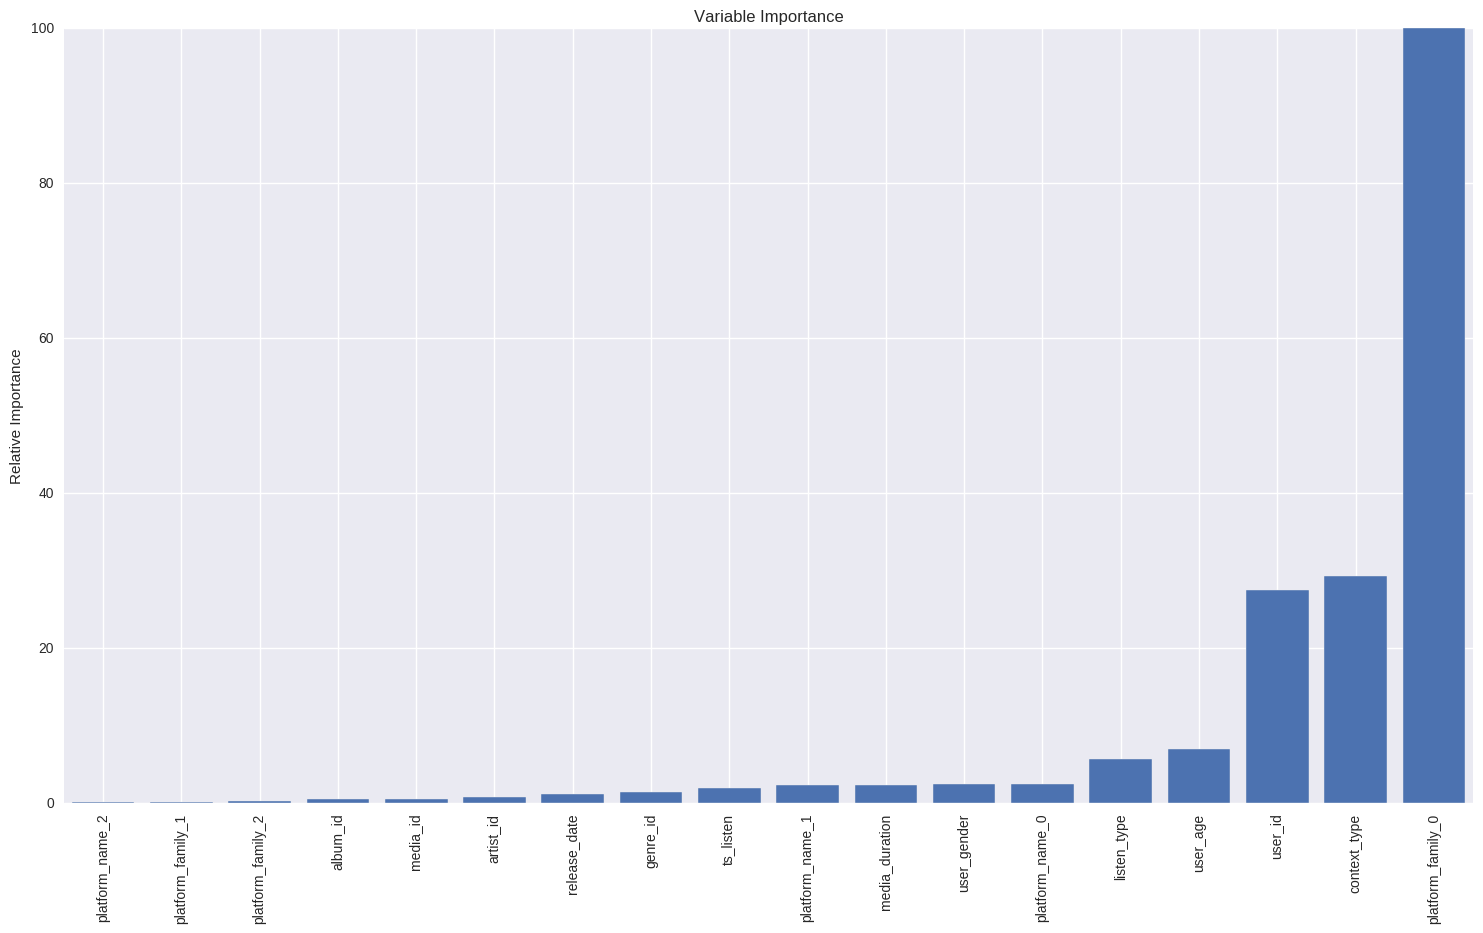

In [21]:
importanceVisualisation(gbr.feature_importances_, newtrain.columns)

<h1> IV - 2. XGBoost </h1>

In [22]:
from sklearn.model_selection import cross_val_predict

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50, plot = False):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    predicted_cv = cross_val_predict(alg, dtrain, target, cv = 5, n_jobs = -1)
    print('AUC Score (CV):',metrics.roc_auc_score(target, predicted_cv))
    
    if plot:
        importanceVisualisation(pd.Series(alg.booster().get_fscore()), predictors)

In [27]:
predictors = newtrain.columns

## FIRST MODEL

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, newtrain, predictors)

## GRID SEARCH ON XGBOOST TO FIND THE BEST PARAMETERS (VERY LONG)

## Grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test1 = {
#  'max_depth':np.array(range(3,10,2)),
#  'min_child_weight':np.array(range(1,6,2))
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch1.fit(newtrain[predictors],target)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## Finer grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test2 = {
#  'max_depth':[2,3,4],
#  'min_child_weight':[2,3,4]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch2.fit(newtrain[predictors],target)
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

## Grid search on 'gamma'

In [ ]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch3.fit(newtrain[predictors],target)
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

## Grid search on 'subsample' and 'colsample_bytree'

In [ ]:
# param_test4 = { 
#  'subsample':[i/10.0 for i in range(6,11)],
#  'colsample_bytree':[i/10.0 for i in range(6,11)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch4.fit(newtrain[predictors],target)
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

## Grid search on 'reg_alpha'

In [ ]:
# param_test6 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test6, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch6.fit(newtrain,target)
# gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
# param_test7 = {
#  'reg_alpha':[0.5,1,2,5,10]
# }
# gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test7, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch7.fit(newtrain,target)
# gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

## Grid search on 'learning_rate' and 'n_estimators'

In [209]:
param_test8 = {
 'learning_rate': [0.1,0.01,0.001],
 'n_estimators': [1000,5000,10000]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0, gamma=0.3, subsample=0.9, reg_alpha = 0.2, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=40), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(newtrain,target)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.80282, std: 0.00984, params: {'n_estimators': 1000, 'learning_rate': 0.1},
  mean: 0.80199, std: 0.01003, params: {'n_estimators': 5000, 'learning_rate': 0.1},
  mean: 0.80175, std: 0.01035, params: {'n_estimators': 10000, 'learning_rate': 0.1},
  mean: 0.81651, std: 0.00992, params: {'n_estimators': 1000, 'learning_rate': 0.01},
  mean: 0.80989, std: 0.00944, params: {'n_estimators': 5000, 'learning_rate': 0.01},
  mean: 0.80797, std: 0.00966, params: {'n_estimators': 10000, 'learning_rate': 0.01},
  mean: 0.81178, std: 0.00623, params: {'n_estimators': 1000, 'learning_rate': 0.001},
  mean: 0.81843, std: 0.00840, params: {'n_estimators': 5000, 'learning_rate': 0.001},
  mean: 0.81649, std: 0.00936, params: {'n_estimators': 10000, 'learning_rate': 0.001}],
 {'learning_rate': 0.001, 'n_estimators': 5000},
 0.8184288230374144)

## FINAL MODEL

In [28]:
# XgbParams = {'learning_rate': 0.001, 'n_estimators':10000, 'max_depth':6, 'min_child_weight':3, 'gamma':0,
#             'subsample':0.9, 'colsample_bytree':0.6, 'reg_alpha':1e-5, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

XgbParams = {'learning_rate': 0.001, 'n_estimators':1000, 'max_depth':5, 'min_child_weight':0, 'gamma':0.3,
            'subsample':0.9, 'colsample_bytree':0.9, 'reg_alpha':0.2, 'objective': 'binary:logistic',
             'nthread':-1, 'scale_pos_weight':1}

# XgbParams = {'learning_rate': 0.01, 'n_estimators':1000, 'max_depth':4, 'min_child_weight':4, 'gamma':0,
#             'subsample':1, 'colsample_bytree':0.6, 'reg_alpha':1, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

In [ ]:
xgb3 = XGBClassifier(**XgbParams, seed=27)
modelfit(xgb3, newtrain, predictors, plot = False)

In [216]:
xgb3 = XGBClassifier(**XgbParams, seed=40)
modelfit(xgb3, newtrain, predictors, plot = False)


Model Report
Accuracy : 0.7944
AUC Score (Train): 0.885769
AUC Score (CV): 0.721147862905


<h1> VI. Final Prediction </h1> (We take the best xgboost model here)

In [30]:
gbrpred = gbr.predict(newtest)
df_output = pd.DataFrame()
df_output['sample_id'] = IDtest
df_output['is_listened'] = gbrpred
df_output[['sample_id','is_listened']].to_csv('./predictions/GBRoutput.csv', sep = ",", index=False)